<a href="https://colab.research.google.com/github/prajwalgangawane/Machine_Learning/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explain the loss function of an Auxiliary Classifier – GAN. Explain each parameter in detail and the observations


In [ ]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from matplotlib import pyplot


In [ ]:
import tensorflow as tf
from keras.layers import Embedding, Reshape, Activation, Concatenate, Conv2DTranspose

In [ ]:
#### Load and preprocess data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train.shape, y_train.shape)
# x_train = x_train.reshape((x_train.shape[0],) + input_shape).astype('float32') / 255.
# y_train = y_train.reshape(-1, 1)
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28) (60000,)


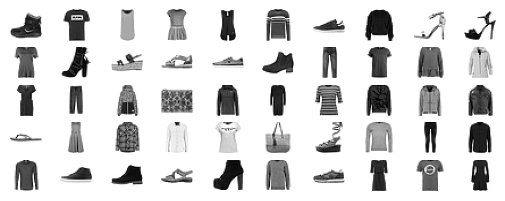

In [ ]:
def display_data(data):
    ## print data
    for i in range(50):
        # define subplot
        plt.subplot(10, 10, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(data[i], cmap='gray_r')
    plt.show()


display_data(x_train)

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    '''
    Discriminator model
    Input: The discriminator model must take as input an image. The input images will have the shape 28x28x1 and there are 10 classes for the items of clothing in the Fashion MNIST dataset.
    Prediction: Both the probability of the ‘realness‘ of the image and the probability of the image belonging to each of the given classes.

    The model can be defined as per the DCGAN architecture. That is,
    - Gaussian weight initialization
    - batch normalization
    - LeakyReLU
    - Dropout,
    - and a 2×2 stride for downsampling instead of pooling layers.
    '''
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
# plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 14, 14, 32)           0         ['leaky_re_lu[0][0]']         
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 128)            0         ['batch_normalization_1[0][0]'
                                                                    ]                             
                                                                                                  
 dropout_2 (Dropout)         (None, 7, 7, 128)            0         ['leaky_re_lu_2[0][0]']       
                                                                                                  
 conv2d_3 (Conv2D)           (None, 7, 7, 256)            295168    ['dropout_2[0][0]']           
                                                                                                  
 batch_normalization_2 (Bat  (None, 7, 7, 256)            1024      ['conv2d_3[0][0]']            
 chNormali

In [ ]:



def define_generator(latent_dim, n_classes=10):
    '''
    Generator model
    The generator model must take a random point from the latent space as input, and the class label, then output a generated grayscale image with the shape 28x28x1.
    '''
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
# plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 18816)                1900416   ['input_3[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_2[0][0]']             
                                                                                            

In [ ]:
def define_gan(g_model, d_model):
    '''
    Composite Model
    Input of the generator model, namely a random point from the latent space and a class label.
    The generator model is connected directly to the discriminator model, which takes the generated image directly as input.
    Finally, the discriminator model predicts both the realness of the generated image and the class label.

    The discriminator model is updated in a standalone manner using real and fake examples, and we will review how to do this in the next section.
    Therefore, we do not want to update the discriminator model when updating (training) the composite model; we only want to use this composite model to update the weights of the generator model.
    This can be achieved by setting the layers of the discriminator as not trainable prior to compiling the composite model.
    This only has an effect on the layer weights when viewed or used by the composite model and prevents them from being updated when the composite model is updated.
    The define_gan() function below implements this, taking the already defined generator and discriminator models as input and defining a new composite model that can be used to update the generator model only.
    '''
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

In [ ]:
# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print("n_steps: ", n_steps)
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 100) == 0:
            summarize_performance(i, g_model, latent_dim)

    return g_model, latent_dim


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
g_model, latent_dim = train(generator, discriminator, gan_model, dataset, latent_dim)

(60000, 28, 28, 1) (60000,)
n_steps:  2340
4/4 [==============================] - 1s 5ms/step
>1, dr[0.814,3.131], df[1.914,3.102], g[0.538,3.224]
4/4 [==============================] - 0s 3ms/step
>2, dr[0.503,3.018], df[1.295,2.963], g[0.804,3.046]
4/4 [==============================] - 0s 3ms/step
>3, dr[0.492,2.988], df[0.969,3.085], g[1.070,3.020]
4/4 [==============================] - 0s 3ms/step
>4, dr[0.648,2.752], df[0.835,3.011], g[1.092,3.070]
4/4 [==============================] - 0s 3ms/step
>5, dr[0.642,2.702], df[0.714,2.886], g[1.248,2.922]
4/4 [==============================] - 0s 3ms/step
>6, dr[0.474,2.464], df[0.643,3.064], g[1.273,3.124]
4/4 [==============================] - 0s 3ms/step
>7, dr[0.526,2.387], df[0.587,2.993], g[1.317,2.987]
4/4 [==============================] - 0s 3ms/step
>8, dr[0.551,2.541], df[0.498,3.178], g[1.203,3.028]
4/4 [==============================] - 0s 4ms/step
>9, dr[0.466,2.229], df[0.626,2.964], g[1.108,3.140]
4/4 [================

In [ ]:
i = 2340
summarize_performance(i, g_model, latent_dim)